In [1]:
import cv2
import glob
import mlflow
import random 
from scipy import io
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.optimizers import *
from keras.models import *
from keras.layers import *
from keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from warnings import filterwarnings
filterwarnings(action='ignore')
from keras.applications import * 
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import *
from keras import regularizers
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, plot_confusion_matrix, ConfusionMatrixDisplay, plot_roc_curve

In [2]:
iterate = np.arange(0, 10000)
iterate = iter(iterate)

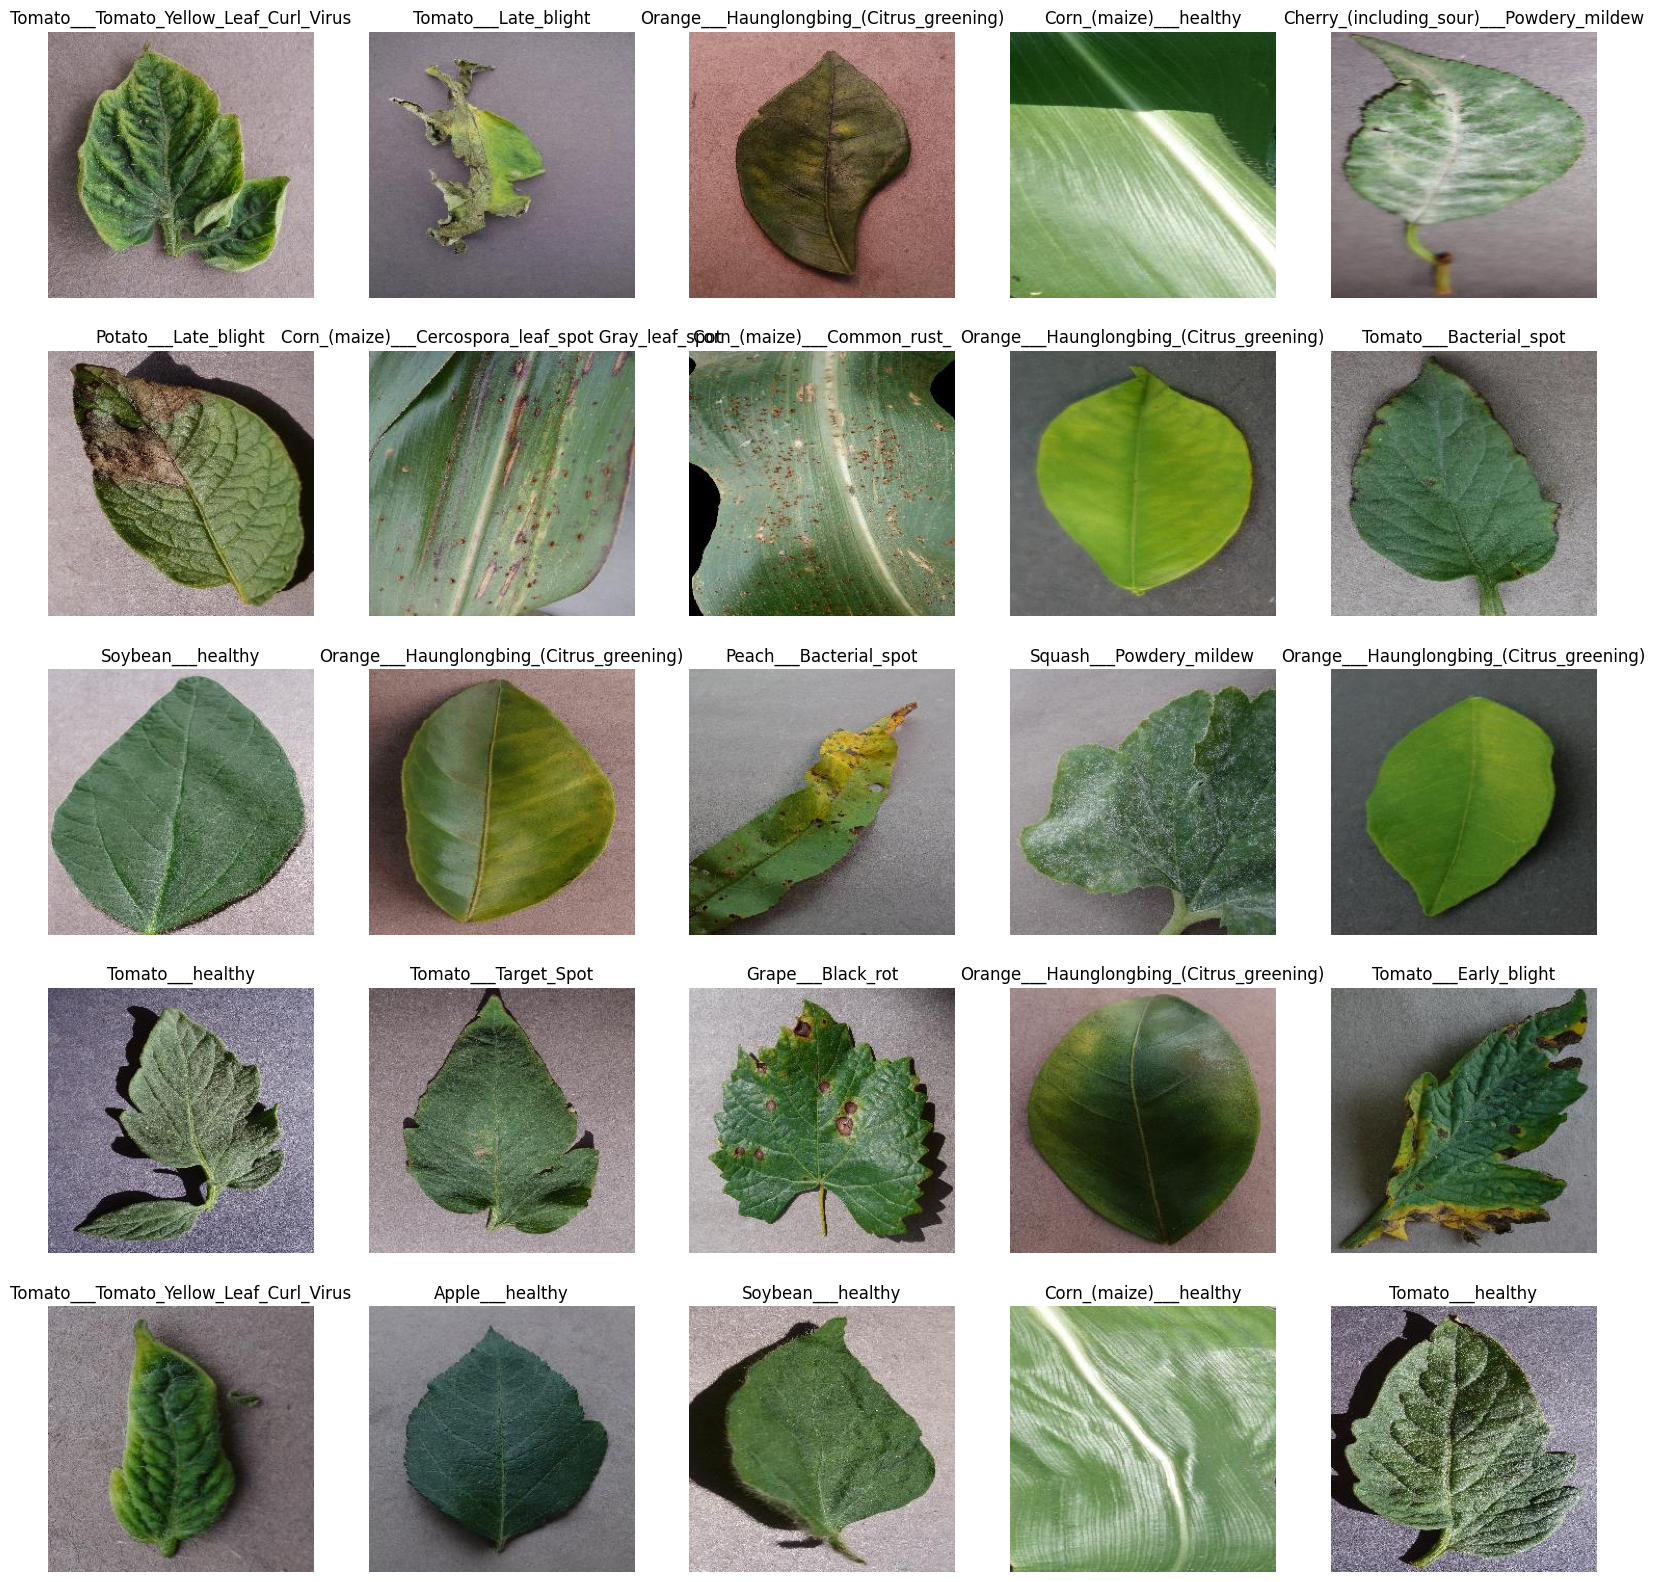

In [3]:
random_imgs = random.sample(glob.glob('plantvillage dataset/color/*/*'), 25)
fig, axes = plt.subplots(5, 5, figsize= (20, 20))
for i, ax in enumerate(axes.flatten()):
    ax.set_title(random_imgs[i].split('\\')[1])
    img = cv2.imread(random_imgs[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [4]:
class Generate_model():
    
    def __init__(self, Version='VGG16', Input_shape=(128, 128, 3), Batch_size=32, lr=1e-3, iterate=iterate):
        self.Version = Version
        self.Input_shape = Input_shape
        self.Batch_size = Batch_size
        self.lr = lr
        self.iterate = iterate

    def Data_Generator(self):
        datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            zoom_range=0.2,
            shear_range=0.2,
            # preprocessing_function=preprocess_input,
            validation_split=0.2
        )

        train = datagen.flow_from_directory(
            'plantvillage dataset/color',
            target_size=(self.Input_shape[0], self.Input_shape[1]),
            class_mode='categorical',
            subset='training',
            batch_size=self.Batch_size,
            shuffle=True,
            seed=0
        )
        val = datagen.flow_from_directory(
            'plantvillage dataset/color',
            target_size=(self.Input_shape[0], self.Input_shape[1]),
            class_mode='categorical',
            subset='validation',
            batch_size=self.Batch_size,
            shuffle=True,
            seed=0
        )
        return train, val
    
    def _select_model(self, train, val):
        
        if self.Version ==  'VGG16':
            Base = VGG16(include_top=False, input_shape=self.Input_shape)
            
        elif self.Version ==  'ResNet':
            Base = ResNet50(include_top=False, input_shape=self.Input_shape)
            
        elif self.Version ==  'MobileNet':
            Base = MobileNet(include_top=False, input_shape=self.Input_shape)
        
        else:
            raise ValueError(f"Invalid Version: {self.Version}")
            
            
        for layer in Base.layers[:-5]:
            layer.trainable = False

        model = Sequential()

        model.add(Base)

        model.add(GlobalAveragePooling2D())

        model.add(Flatten())

        model.add(BatchNormalization())

        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu',
                        # kernel_regularizer=regularizers.l1_l2(l1=0.9, l2=0.9)
                 ))

        model.add(Dropout(0.2))
        model.add(Dense(128, activation='relu', 
                        # kernel_regularizer=regularizers.l1_l2(l1=0.9, l2=0.9)
                 ))
        model.add(Dropout(0.2))

        model.add(Dense(38, activation='softmax'))
        model.compile(Adam(lr= self.lr), loss='categorical_crossentropy', metrics=['accuracy', 'Recall', 'Precision'])

        history = model.fit(train, validation_data=val, batch_size=self.Batch_size, epochs=200,
                           callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
                           )
        return model, history, model.summary()
    
    def artifacts(self, model, history):

        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.savefig(f'images/Accuracy_Run({self.iterate})')
        plt.show()
        plt.close()

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.savefig(f'images/Loss_Run({self.iterate})')
        plt.show()
        plt.close()

        plt.plot(history.history['recall'])
        plt.plot(history.history['val_recall'])
        plt.title('Model Recall')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.savefig(f'images/Recall_Run({self.iterate})')
        plt.show()
        plt.close()

        plt.plot(history.history['precision'])
        plt.plot(history.history['val_precision'])
        plt.title('Model precision')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.savefig(f'images/Prescision_Run({self.iterate})')
        plt.show()
        plt.close()
        
    def train_model(self):
        train, val = self.Data_Generator()
        model, history, summary = self._select_model(train, val)
        self.artifacts(model, history)
        return model, history, summary

Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


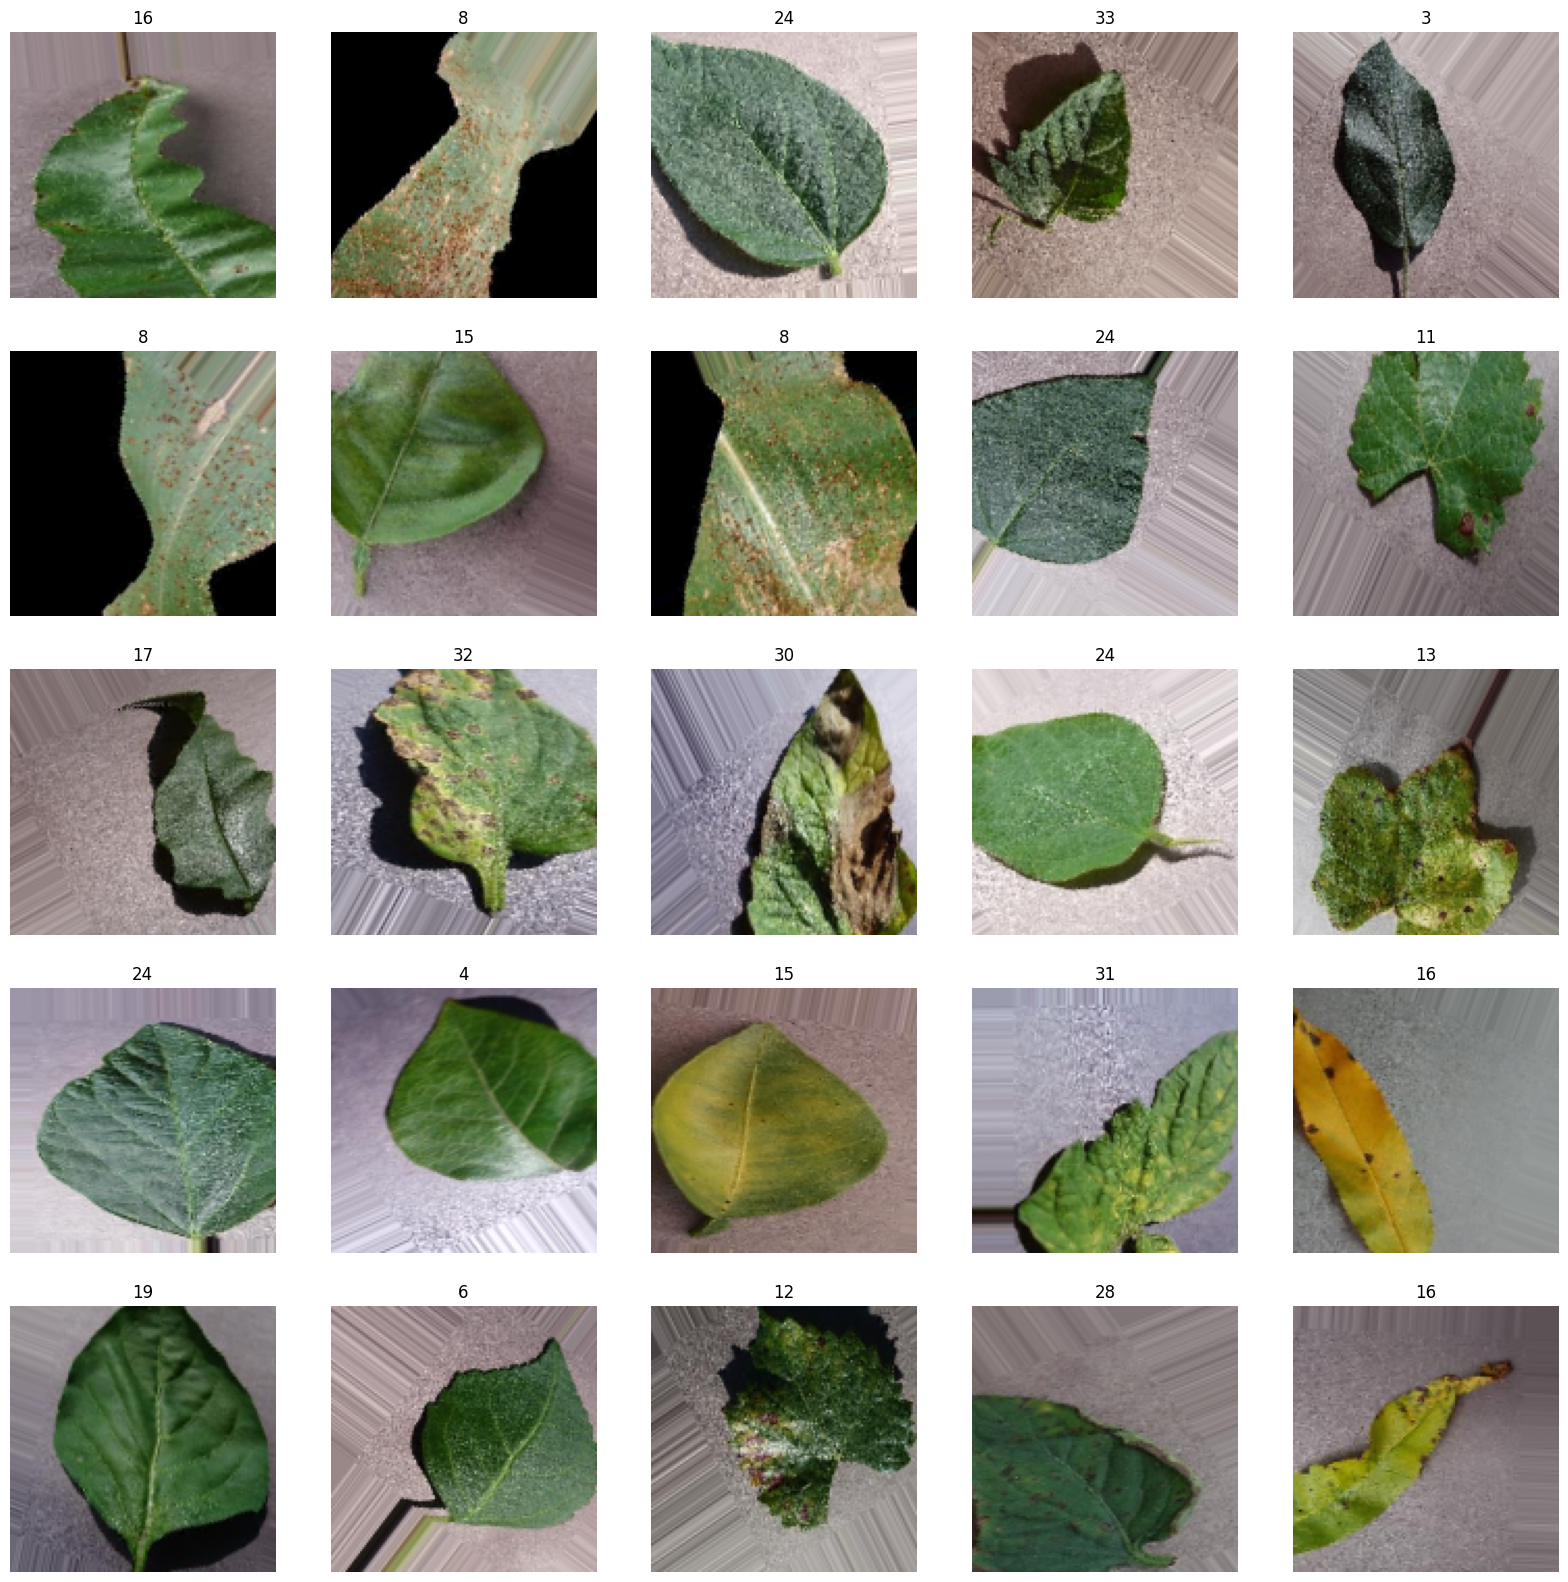

In [5]:
train, val = Generate_model().Data_Generator()
fig, axes = plt.subplots(5, 5, figsize= (20, 20))
for i, ax in enumerate(axes.flatten()):
    ax.set_title(np.argmax(train[0][1][i]))
    ax.imshow(train[0][0][i])
    ax.axis('off')
    
plt.show()

In [ ]:
Version = 'VGG16'
iterate = next(iterate)

mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment(experiment_name=Version)
mlflow.start_run(run_name=f"run_{iterate}")
mlflow.tensorflow.autolog()

model_generator = Generate_model(Version=Version, Input_shape=(128, 128, 3), Batch_size=32, lr=1e-3, iterate=iterate)

model, history, summary = model_generator.train_model()

mlflow.log_artifact(f'images/Accuracy_Run({iterate}).png')
mlflow.log_artifact(f'images/Loss_Run({iterate}).png')
mlflow.log_artifact(f'images/Recall_Run({iterate}).png')
mlflow.log_artifact(f'images/Prescision_Run({iterate}).png')


train_metrics = model.evaluate(train) 
val_metrics = model.evaluate(val)

mlflow.log_metric('loss', train_metrics[0])
mlflow.log_metric('accuracy', train_metrics[1])
mlflow.log_metric('recall', train_metrics[2])
mlflow.log_metric('precision', train_metrics[3])

mlflow.log_metric('val_loss', val_metrics[0])
mlflow.log_metric('val_accuracy', val_metrics[1])
mlflow.log_metric('val_recall', val_metrics[2])
mlflow.log_metric('val_precision', val_metrics[3])

mlflow.tensorflow.log_model(model, 'model')

mlflow.end_run()

2023/07/27 10:47:16 INFO mlflow.tracking.fluent: Experiment with name 'VGG16' does not exist. Creating a new experiment.


Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.
Epoch 1/200
1358/1358 [==============================] - 1123s 819ms/step - loss: 1.0390 - accuracy: 0.6844 - recall: 0.5888 - precision: 0.8232 - val_loss: 0.7823 - val_accuracy: 0.7409 - val_recall: 0.6545 - val_precision: 0.8415
Epoch 2/200
1358/1358 [==============================] - 492s 362ms/step - loss: 0.5394 - accuracy: 0.8253 - recall: 0.7818 - precision: 0.8751 - val_loss: 0.6091 - val_accuracy: 0.8040 - val_recall: 0.7614 - val_precision: 0.8645
Epoch 3/200
1358/1358 [==============================] - 239s 176ms/step - loss: 0.4327 - accuracy: 0.8595 - recall: 0.8275 - precision: 0.8970 - val_loss: 0.3959 - val_accuracy: 0.8681 - val_recall: 0.8414 - val_precision: 0.9004
Epoch 4/200
1358/1358 [==============================] - 233s 171ms/step - loss: 0.3694 - accuracy: 0.8817 - recall: 0.8555 - precision: 0.9101 - val_loss: 0.4400 - val_accuracy: 0.8604 - val_recall: 0.8371 - val_preci

In [9]:
mlflow.end_run()